# code from 
https://github.com/amitadate/S-LSTM-GAN-MNIST

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
# matplotlib.use('Agg') # Force matplotlib to not use any Xwindows backend.
import matplotlib.pyplot as plt
import os 
from tensorflow.examples.tutorials.mnist import input_data


In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
class RNN_MNIST_model(object):
	def __init__(self, config, is_training = True, model_type="FULL"):
		batch_size = config.batch_size  #128
		z_size = config.z_size          #100

		lstm_layers_RNN_g = config.lstm_layers_RNN_g   #6
		lstm_layers_RNN_d = config.lstm_layers_RNN_d   #2

		hidden_size_RNN_g = config.hidden_size_RNN_g   #600
		hidden_size_RNN_d = config.hidden_size_RNN_d   #400


		self.target = tf.placeholder(tf.float32, [batch_size, 10])   #(128, 10) 
                                                                     #(flatten image portion + one hot target)
		self.target_bin = tf.placeholder(tf.float32, [batch_size, 2]) #(128, 2)  

		self.trainables_variables = []

		if model_type == "GEN" or model_type == "FULL":
			self.z = tf.placeholder(tf.float32, [batch_size, z_size])      #(128, 100)
            
			# linear trans for z -> hidden_size_RNN_g
			f_w = tf.get_variable("RNN_g_w", [z_size, hidden_size_RNN_g])  #(100, 600)
			f_b = tf.get_variable("RNN_g_b", [hidden_size_RNN_g])          #(600)

			self.trainables_variables.append(f_w)
			self.trainables_variables.append(f_b)

			init_state = tf.matmul(self.z, f_w) + f_b                      #(128, 600)         
			collected_state = ((init_state, init_state),)
			for layer in range(config.lstm_layers_RNN_g - 1):
				collected_state += ((init_state, init_state),)  

			init_image = tf.zeros([batch_size,14*14])     #(128, 196) 
			init_input = tf.concat( [init_image, self.target], 1)  #(128, 196 + 10) (flatten image portion + one hot target)

			# linear trans for [x_image_size * y_image_size + num_classes] -> hidden_size_RNN_g 
			g_w = tf.get_variable("RNN_g_input_target_w", [(14*14)+10, hidden_size_RNN_g])    # ((14*14)+10, 600)
			g_b = tf.get_variable("RNN_g_input_target_b", [hidden_size_RNN_g])                # 600

			self.trainables_variables.append(g_w)
			self.trainables_variables.append(g_b)

			# linear trans for hidden_size_RNN_g -> [x_image_size * y_image_size] 
			h_w = tf.get_variable("RNN_g_output_target_w", [hidden_size_RNN_g, (14*14)])      # (600, (14*14))
			h_b = tf.get_variable("RNN_g_output_target_b", [(14*14)]) 

			self.trainables_variables.append(h_w)
			self.trainables_variables.append(h_b)
            
			lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_RNN_g, forget_bias=0.0, state_is_tuple=True)  #600
			cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers_RNN_g, state_is_tuple=True)    #6

			output = []
			cell_input = tf.matmul(init_input, g_w) + g_b  # (128, 600)
			self.state = state = collected_state

			lstm_variables = []
            

			with tf.variable_scope("RNN_g") as vs:
				for time_step in range(4): 
					if time_step > 0: tf.get_variable_scope().reuse_variables()
                        
					(cell_output, state) = cell(tf.nn.relu(cell_input), state)   #(128, 600)
            
					cell_output = tf.matmul(cell_output, h_w) + h_b             #(128, 196)
					output.append(cell_output)  
                    
					new_input = tf.concat([cell_output, self.target],1)  # (128, (14*14)+10) = (128, 206)
					cell_input = tf.matmul(new_input, g_w) + g_b                #(128, 600)

				lstm_variables = [v for v in tf.global_variables()
                    if v.name.startswith(vs.name)]

			self.trainables_variables += lstm_variables
            
			# output = (4, 128, 196)
			outputs_RNN_g = tf.transpose(output, perm=[1,0,2])  #(128, 4, 196)
			outputs_RNN_g = tf.nn.relu(outputs_RNN_g)           

			output_max = tf.reduce_max(outputs_RNN_g, reduction_indices=2)  #(128, 4)
			output_max = tf.expand_dims(output_max, -1)                     #(128, 4, 1) 
			output_max = tf.tile(output_max, [1,1,14*14])                   #(128, 4, 196) 

			stabalizer = tf.ones(tf.shape(output_max)) * 1e-7               #(128, 4, 196) 

			outputs_RNN_g = tf.div(outputs_RNN_g, output_max + stabalizer) 
            
			if model_type == "GEN":	
				self.outputs = outputs_RNN_g   #(64, 4, 196) 

        
        
		########################## Discriminator #############################################
		if model_type == "DISC" or model_type == "FULL":
			if model_type == "DISC":
				self.image_input = tf.placeholder(tf.float32, [batch_size, 4, 14*14])  #(128, 4, 196)
			else:
				self.image_input = outputs_RNN_g       #(128, 4, 196)

			cell = tf.nn.rnn_cell.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(hidden_size_RNN_d, forget_bias=0.0, state_is_tuple=True),
                          output_keep_prob=config.keep_prob) for _ in range(config.lstm_layers_RNN_d)]) #400*2=800
    
####################################################################################################################

			# linear trans for [x_image_size * y_image_size + num_classes] -> hidden_size_RNN_g
			i_w = tf.get_variable("RNN_d_target_w", [10, hidden_size_RNN_d])    #(10, 400)
			i_b = tf.get_variable("RNN_d_target_b", [hidden_size_RNN_d])        #(400)

			if model_type == "DISC":
				self.trainables_variables.append(i_w)
				self.trainables_variables.append(i_b)
                
			init_state_input = tf.matmul(self.target, i_w) + i_b                #(128, 400)
			init_state = (tf.nn.rnn_cell.LSTMStateTuple(init_state_input, init_state_input),)
			for layer in range(config.lstm_layers_RNN_d - 1): #2-1
				init_state += (tf.nn.rnn_cell.LSTMStateTuple(init_state_input, init_state_input),)
			#init_state2 = tf.nn.rnn_cell.LSTMStateTuple(init_state, init_state)

            
			lstm_variables = []

			with tf.variable_scope("RNN_d") as vs:
				output, _ = tf.nn.dynamic_rnn(  #(128, 4, 400)
		      		cell,
		      		self.image_input,         # (128, 4, 196)
		      		initial_state = init_state,
		      		dtype=tf.float32,
		      	)

				lstm_variables = [v for v in tf.all_variables()
                    if v.name.startswith(vs.name)]				
            
			if model_type == "DISC":
				self.trainables_variables += lstm_variables

			# linear trans for hidden_size of lstm -> single value
			j_w = tf.get_variable("RNN_j_prob_w", [hidden_size_RNN_d, 2])  #(400, 2)
			j_b = tf.get_variable("RNN_j_prob_b", [2])

			if model_type == "DISC":
				self.trainables_variables.append(j_w)
				self.trainables_variables.append(j_b)

			final_output = tf.slice(output, [0,3,0], [batch_size, 1, hidden_size_RNN_d])   #(128, 1, 400) 
			final_output = tf.squeeze(final_output, [1])                                   #(128, 400)
			final_trans = tf.matmul(final_output, j_w) + j_b                               #(128, 2)
			
			self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = final_trans, labels = self.target_bin))
###########################################################
			# weight decay
			l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in self.trainables_variables])
			lambda_coeff = 0.00001

			self.cost = self.cost + lambda_coeff * l2_loss

			correct_pred = tf.equal(tf.argmax(final_trans,1), tf.argmax(self.target_bin,1))
			self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

			self.lr = config.lr
			grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, self.trainables_variables),  
			                                   config.max_grad_norm)
			self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
			self.train_op = self.optimizer.apply_gradients(zip(grads, self.trainables_variables))

		# model ends

In [5]:
def getinput(batch_x):  #(64, 784)
    # spliting the image into its quadrants, then flattening, then concatenating
    
    full_im = np.reshape(batch_x,(configobj().batch_size//2, 28,28)) #(64, 28, 28)
    
    split_ul = full_im[:,0:14,0:14]                                  #(64, 14, 14)
    split_ul = np.reshape(split_ul, (configobj().batch_size//2, 14*14)) #(64, 196)
    split_ul = np.expand_dims(split_ul, axis=1)                      #(64, 1, 196)
    
    split_ur = full_im[:,0:14,14:28]                                 #(64, 14, 14)
    split_ur = np.reshape(split_ur, (configobj().batch_size//2, 14*14)) #(64, 196)
    split_ur = np.expand_dims(split_ur, axis=1)                      #(64, 1, 196)
    
    split_ll = full_im[:,14:28,0:14]                                 #(64, 14, 14)
    split_ll = np.reshape(split_ll, (configobj().batch_size//2, 14*14)) #(64, 196)
    split_ll = np.expand_dims(split_ll, axis=1)                      #(64, 1, 196)
    
    split_lr = full_im[:,14:28,14:28]                               #(64, 14, 14)
    split_lr = np.reshape(split_lr, (configobj().batch_size//2, 14*14)) #(64, 196)
    split_lr = np.expand_dims(split_lr, axis=1)                      #(64, 1, 196)
    
    input_x = np.concatenate((split_ul, split_ur, split_ll, split_lr), axis=1)  #(64, 4, 196)
    
    return input_x

In [6]:
class configobj(object):
    batch_size = 2**7
    keep_prob = 0.5
    z_size = 100
    lstm_layers_RNN_g = 6
    lstm_layers_RNN_d = 2
    hidden_size_RNN_g = 600
    hidden_size_RNN_d = 400
    lr = 0.0001
    max_grad_norm = 10
    # iterations = 10**7
    iterations = 10
    init_scale = 0.01

class configobj_f(object):
    batch_size = 2**7
    keep_prob = 0.5
    z_size = 100
    lstm_layers_RNN_g = 6
    lstm_layers_RNN_d = 2
    hidden_size_RNN_g = 600
    hidden_size_RNN_d = 400
    lr = 0.0002
    max_grad_norm = 10
    # iterations = (10**6)
    iterations = 10
    init_scale = 0.01

class configobj_g(object):
    batch_size = 2**6
    keep_prob = 0.005
    z_size = 100
    lstm_layers_RNN_g = 6
    lstm_layers_RNN_d = 2
    hidden_size_RNN_g = 600
    hidden_size_RNN_d = 400
    lr = 0.0001
    max_grad_norm = 10
    # iterations = 10**5
    iterations = 10
    init_scale = 0.01

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instru

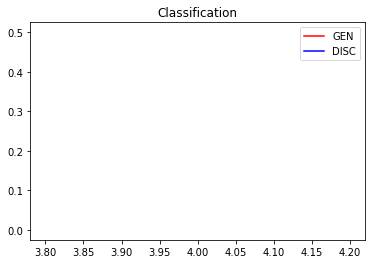

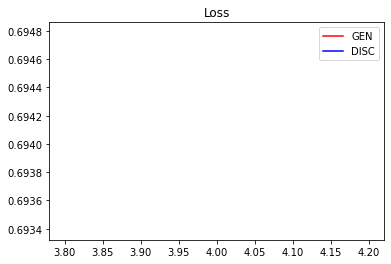

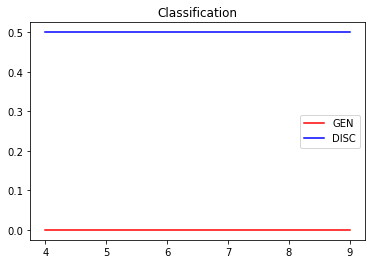

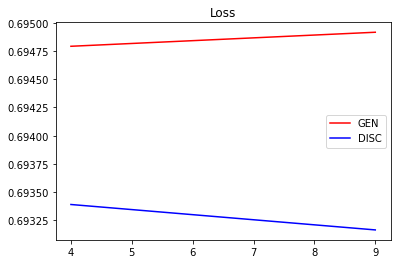

In [7]:
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as session:
    initializer = tf.random_uniform_initializer(-configobj().init_scale,configobj().init_scale) 

    with tf.variable_scope("model_full", reuse=None, initializer=initializer):
        mod_f = RNN_MNIST_model(configobj_f(), True, model_type="FULL")
        
    with tf.variable_scope("model_full", reuse=True, initializer=initializer):
        mod_g = RNN_MNIST_model(configobj_g(), False, model_type="GEN")
        
    # with tf.variable_scope("model_full", reuse=True, initializer=initializer):
    with tf.variable_scope("model_full", reuse = tf.AUTO_REUSE, initializer=initializer):
        mod_d = RNN_MNIST_model(configobj(), True, model_type="DISC")

    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    x_plot_class_g = []           #Generator  loss
    y_plot_class_g = []
    accumulator_class_g = 0
    stepsingen_class_g = 0

    x_plot_loss_g = []            #Generator GAN loss
    y_plot_loss_g = []
    accumulator_loss_g = 0
    stepsingen_loss_g = 0

    x_plot_class_d = []           #Discriminator  loss
    y_plot_class_d = []
    accumulator_class_d = 0
    stepsingen_class_d = 0

    x_plot_loss_d = []            #Discriminator GAN loss
    y_plot_loss_d = []
    accumulator_loss_d = 0
    stepsingen_loss_d = 0

    for i in range(configobj().iterations): # epoch
     
        # update the generator
        if ((i+1) % 2 == 0):
            z = np.random.uniform(-1,1,(configobj().batch_size,configobj().z_size))  #(128, 100)

            # randomly generating one-hot vector to describe gen number image segments
            target_gen = np.zeros((configobj().batch_size, 10))  # (128, 10)
            ind = [np.random.choice(10) for row in target_gen]   # len = 128
            target_gen[range(target_gen.shape[0]), ind] = 1      #
            
            target_gen_bin = np.zeros((configobj().batch_size, 2)) # (128, 2)  
            target_gen_bin[:,0] = 1   

            _, cost_gen_g, acc_gen_g = session.run((mod_f.train_op, mod_f.cost, mod_f.accuracy),
                                      feed_dict={mod_f.z: z, 
                                                 mod_f.target_bin: target_gen_bin, 
                                                 mod_f.target: target_gen})

            accumulator_class_g += acc_gen_g
            stepsingen_class_g += 1

            accumulator_loss_g += cost_gen_g
            stepsingen_loss_g += 1
#             print('enter')
        # update the discriminator
        else :
            ################################### real part ###################################
            batch_x, batch_y = mnist.train.next_batch(configobj().batch_size//2)
            batch_x = getinput(batch_x)   #(64, 4, 196)
            
            target_bin = np.zeros((configobj().batch_size//2, 2))  #(64, 2)
            target_bin[:,0] = 1   
            ################################### real part ###################################

            ################################### fake part ###################################
            z = np.random.uniform(-1,1,(configobj().batch_size//2,configobj().z_size))  #(64, 100)

            # randomly generating one-hot vect to describe gen number image segments
            target_gen = np.zeros((configobj().batch_size//2, 10))      #(64, 10)
            ind = [np.random.choice(10) for row in target_gen]          # len = 64
            target_gen[range(target_gen.shape[0]), ind] = 1             #
            
            target_gen_bin = np.zeros((configobj().batch_size//2, 2))   #(64, 2)
            target_gen_bin[:,1] = 1     
            ################################### fake part ###################################

            gen_x = session.run((mod_g.outputs),                        #(64, 4, 196)
                                feed_dict={mod_g.z:z, 
                                           mod_g.target:target_gen,     #(64, 10)
                                           mod_g.target_bin:target_gen_bin})  #(64, 2)

            # trying to shuffle fake and real data
            x = np.concatenate((batch_x, gen_x), axis=0)                #(128, 4, 196)
            t = np.concatenate((batch_y, target_gen), axis=0)           #(128, 10)
            y = np.concatenate((target_bin, target_gen_bin), axis=0)    #(128, 2)  


            c = np.concatenate((x.reshape(len(x), -1), y.reshape(len(y), -1), t.reshape(len(t), -1)), axis=1)  
            #(128,  4*196 + 10 + 2 ) = (128, 796)

            np.random.shuffle(c)

            x = c[:, :x.size//len(x)].reshape(x.shape)   #data                             #(128, 4, 196)
            y = c[:, x.size//len(x):(x.size//len(x))+(y.size//len(y))].reshape(y.shape)    #(128, 2)
            t = c[:, (x.size//len(x))+(y.size//len(y)):].reshape(t.shape)                  #(128, 10)

            _, cost, acc = session.run((mod_d.train_op, mod_d.cost, mod_d.accuracy),
                                       feed_dict={mod_d.target_bin:y,
                                                  mod_d.target:t, 
                                                  mod_d.image_input:x})

            accumulator_class_d += acc
            stepsingen_class_d += 1

            accumulator_loss_d += cost
            stepsingen_loss_d += 1

        if ((i+1) % 100000 == 0):
#         if ((i+1) % 2 == 0):
            save_path = saver.save(session, "model_quad_3.ckpt")
            print("Model saved in file: %s" % save_path)
        
#         if ((i+1) % 1000 == 0):
        if ((i+1) % 5 == 0):
            print("------------")
            print("Step: {}".format(i+1))

            print("************")
            print(cost_gen_g)
            print("Loss: {}, Accuracy: {}".format(cost_gen_g, acc_gen_g))
            print("************")

            #print((cost + cost_gen) / 2)
            print("Loss: {}, Accuracy: {}".format(cost, acc))

            x_plot_class_g.append(i)
            y_plot_class_g.append(accumulator_class_g/stepsingen_class_g)

            accumulator_class_g = 0
            stepsingen_class_g = 0

            x_plot_class_d.append(i)
            y_plot_class_d.append(accumulator_class_d/stepsingen_class_d)

            accumulator_class_d = 0
            stepsingen_class_d = 0

            plt.figure()
            class_plt_g, = plt.plot(x_plot_class_g, y_plot_class_g, 'r-')
            class_plt_d, = plt.plot(x_plot_class_d, y_plot_class_d, 'b-')
            plt.legend([class_plt_g, class_plt_d], ["GEN", "DISC"])
            plt.title('Classification')
            plt.savefig('classification_3.png')

            x_plot_loss_g.append(i)
            y_plot_loss_g.append(accumulator_loss_g/stepsingen_loss_g)

            accumulator_loss_g = 0
            stepsingen_loss_g = 0

            x_plot_loss_d.append(i)
            y_plot_loss_d.append(accumulator_loss_d/stepsingen_loss_d)

            accumulator_loss_d = 0
            stepsingen_loss_d = 0

            plt.figure()
            loss_plt_g, = plt.plot(x_plot_loss_g, y_plot_loss_g, 'r-')
            loss_plt_d, = plt.plot(x_plot_loss_d, y_plot_loss_d, 'b-')
            plt.legend([loss_plt_g, loss_plt_d], ["GEN", "DISC"])
            plt.title('Loss')
            plt.savefig('loss_3.png')

        
print('all is okay')